In [2]:
import os
import csv
import torch
import pandas as pd
import matplotlib.pyplot as plt

from gpolnel.utils.datasets import load_boston
from torch.utils.data import TensorDataset, DataLoader
from itertools import product, combinations
from tqdm import tqdm
import random

from gpolnel.problems.inductive_programming import SML, SMLGS
from gpolnel.utils.utils import train_test_split
from gpolnel.utils.ffunctions import Ffunctions
from gpolnel.utils.inductive_programming import function_map
from gpolnel.algorithms.genetic_algorithm import GSGP, GeneticAlgorithm
from gpolnel.operators.initializers import grow, full, rhh, prm_grow, ERC, prm_full
from gpolnel.operators.variators import swap_xo, prm_subtree_mtn, prm_point_mtn, prm_hoist_mtn, prm_gs_xo, prm_gs_mtn, prm_efficient_gs_xo, prm_efficient_gs_mtn
from gpolnel.operators.selectors import prm_tournament, prm_roulette_wheel, prm_rank_selection, prm_rnd_selection, prm_double_tournament

seed = 19
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

# Defines parameters for the data usage
shuffle, p_test, p_val, n_batches_pct = True, .3, .3, 1

csv_file_path = './datamart/data_project_nel_final.csv'

# Read the CSV file into a DataFrame
dt = pd.read_csv(csv_file_path)
X = torch.from_numpy(dt.values[:, :-1]).float().to(device)

csv_file_path = './datamart/y_lactose.csv'

y_lactose = pd.read_csv(csv_file_path)
y = torch.from_numpy(y_lactose.values[:, -1]).float().to(device)

print(X.shape, y.shape)
print(X[:3])
print(y[:3])

# Data split

# Train and test sets
train_indices, test_indices = train_test_split(
    X=X, y=y, p_test=p_test, shuffle=shuffle, indices_only=True, seed=seed
)
# Train and val sets
val_indices = train_indices[:int(train_indices.shape[0]*p_val)]
train_indices = train_indices[int(train_indices.shape[0]*p_val):]
total_batches = 1
batch_size = train_indices.shape[0]
print('Batch size: {}\nTotal batches: {}\n'.format(batch_size, total_batches))
print([train_indices.shape, val_indices.shape, test_indices.shape])


# Defines GSM’s steps
to, by = 5.0, 0.25
ms = torch.arange(by, to + by, by, device=device)

print(ms)

selected_function_combinations = [
    (function_map['add'], function_map['sub'], function_map['mul'], function_map['div']),
    (function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['log']),
    (function_map['add'], function_map['sub'], function_map['mul'], function_map['div'], function_map['exp'], function_map['tanh']),
]

constant_sets = [ERC(-1., 1.), ERC(-5., 5.), ERC(-10., 10.)]
p_constants_values = [0.05, 0.1, 0.2]
max_init_depth_values = [3, 5, 7]
max_depth_values = [10, 15, 20]

# Generate all combinations of the parameters
sspace_combinations = list(product(selected_function_combinations, constant_sets, p_constants_values, max_init_depth_values, max_depth_values))

initializers = [grow, full, rhh]
selectors = [prm_tournament, prm_roulette_wheel, prm_rank_selection, prm_rnd_selection, prm_double_tournament]
ps = [50, 100, 250, 500]
selection_pressure = [0.05, 0.1, 0.2]
mutation_prob = [0.01, 0.05, 0.1]
xo_prob = [0.7, 0.8, 0.9]
has_elitism = [True, False]
allow_reproduction = [True, False]

# Generate all combinations of the genetic algorithm parameters
ga_combinations = list(product(initializers, selectors, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction))

# Combine both sets of combinations for full testing
all_combinations = [ga_params + sspace_params for ga_params, sspace_params in product(ga_combinations, sspace_combinations)]

selected_combinations = random.sample(all_combinations, 50)

best_sol = float('inf')
best_params = {}

def test_genetic_algorithm(fset, cset, p_constants, max_init_depth, max_depth, initializer, selector, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction):
    global best_sol, best_params

    sspace_sml = {
        'n_dims': X.shape[1],
        'function_set': fset, 
        'constant_set': cset,
        'p_constants': p_constants,
        'max_init_depth': max_init_depth,
        'max_depth': max_depth, 
        'n_batches': total_batches,
        'device': device
    }

    pi_sml_gs = SMLGS(
        sspace=sspace_sml,
        ffunction=Ffunctions('rmse'),
        X=X, y=y,
        train_indices=train_indices,
        test_indices=val_indices
    )

    if initializer == grow:
        mutator = prm_efficient_gs_mtn(X, prm_grow(sspace_sml), ms)
        crossover = prm_efficient_gs_xo(X, prm_grow(sspace_sml))
    else: #initializer == full:
        mutator = prm_efficient_gs_mtn(X, prm_full(sspace_sml), ms)
        crossover = prm_efficient_gs_xo(X, prm_full(sspace_sml))
    #else:  # initializer == rhh
        #mutator = prm_efficient_gs_mtn(X, prm_rhh(sspace_sml), ms)
        #crossover = prm_efficient_gs_xo(X, prm_rhh(sspace_sml))

    if selector == prm_tournament:
        selector = prm_tournament(pressure=selection_pressure)
    elif selector == prm_double_tournament:
        selector = prm_double_tournament(selection_pressure, selection_pressure)
    else: 
        selector = selector()


    mheuristic = GSGP(
        pi=pi_sml_gs,
        initializer=initializer,
        selector=selector,
        pop_size=ps,
        p_m=mutation_prob,
        p_c=xo_prob,
        elitism=has_elitism,
        reproduction=allow_reproduction, 
        device=device,
        seed=seed,
        crossover=crossover,
        mutator=mutator
    )

    mheuristic._initialize()

    n_iter = 50
    mheuristic.solve(
        n_iter,
        test_elite=True
    )
    
    current_sol = float(mheuristic.best_sol.test_fit.item())
    
    if current_sol < best_sol:
        best_sol = current_sol
        best_params = (
            fset, cset, p_constants, max_init_depth, max_depth, initializer, selector, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction
        )

    return best_params, best_sol

from tqdm import tqdm

for combo in tqdm(selected_combinations, desc="Testing Combinations"):
    initializer, selector, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction, fset, cset, p_constants, max_init_depth, max_depth = combo
    test_genetic_algorithm(
        fset=fset, cset=cset, p_constants=p_constants, max_init_depth=max_init_depth, max_depth=max_depth, 
        initializer=initializer, selector=selector, ps=ps, selection_pressure=selection_pressure,
        mutation_prob=mutation_prob, xo_prob=xo_prob, has_elitism=has_elitism, allow_reproduction=allow_reproduction
    )

print(f"Best Parameters: {best_params}")
print(f"Best Solution: {best_sol}")


torch.Size([324, 12]) torch.Size([324])
tensor([[ 2.5000,  2.7273,  2.0000, -0.5206, -1.3631, -0.5860,  0.7581, -0.5366,
          0.8808,  0.0000,  0.0000, -0.4190],
        [ 3.0000,  3.4545,  0.8657, -0.7277,  0.6837, -0.3605,  1.0324, -0.8866,
          0.0796,  0.0000,  0.0000, -0.6626],
        [ 2.0000,  2.6818,  0.0299,  0.3326,  0.0628,  0.4168, -0.0605, -0.6421,
          0.1936,  0.0000,  0.1330, -0.5441]])
tensor([4.9535, 4.9831, 4.8891])
Batch size: 159
Total batches: 1

[torch.Size([159]), torch.Size([68]), torch.Size([97])]
tensor([0.2500, 0.5000, 0.7500, 1.0000, 1.2500, 1.5000, 1.7500, 2.0000, 2.2500,
        2.5000, 2.7500, 3.0000, 3.2500, 3.5000, 3.7500, 4.0000, 4.2500, 4.5000,
        4.7500, 5.0000])


Testing Combinations: 100%|████████████████████████████████████████████████████████████| 50/50 [28:19<00:00, 33.98s/it]

Best Parameters: ((add, sub, mul, div, exp, tanh), <gpolnel.operators.initializers.ERC object at 0x0000017D97A75850>, 0.2, 3, 15, <function full at 0x0000017D97CACF40>, <function prm_double_tournament.<locals>.double_tournament at 0x0000017DB5D8C220>, 250, 0.1, 0.1, 0.8, True, False)
Best Solution: 0.07223016768693924


In [4]:
fset, cset, p_constants, max_init_depth, max_depth, initializer, selector, ps, selection_pressure, mutation_prob, xo_prob, has_elitism, allow_reproduction = best_params

In [5]:
best_params

((add, sub, mul, div, exp, tanh),
 0.2,
 3,
 15,
 <function gpolnel.operators.initializers.full(sspace, n_sols)>,
 <function gpolnel.operators.selectors.prm_double_tournament.<locals>.double_tournament(pop, min_criteria)>,
 250,
 0.1,
 0.1,
 0.8,
 True,
 False)

In [6]:
sspace_sml = {
    'n_dims': X.shape[1],
    'function_set': fset, 
    'constant_set': cset,
    'p_constants': p_constants,
    'max_init_depth': max_init_depth,
    'max_depth': max_depth, 
    'n_batches': total_batches,
    'device': device
}

pi_sml_gs = SMLGS(
    sspace=sspace_sml,
    ffunction=Ffunctions('rmse'),
    X=X, y=y,
    train_indices=train_indices,
    test_indices=test_indices
)

mutator = prm_efficient_gs_mtn(X, prm_grow(sspace_sml), ms) if initializer == grow else prm_efficient_gs_mtn(X, prm_full(sspace_sml), ms)
crossover = prm_efficient_gs_xo(X, prm_grow(sspace_sml)) if initializer == grow else prm_efficient_gs_xo(X, prm_full(sspace_sml))

mheuristic = GSGP(
    pi=pi_sml_gs,
    initializer=initializer,
    selector=selector,
    crossover=crossover,
    mutator=mutator,
    pop_size=ps,
    p_m=mutation_prob,
    p_c=xo_prob,
    elitism=has_elitism,
    reproduction=allow_reproduction,
    device=device,
    seed=seed
)

mheuristic._initialize()

# Log settings
file_dir = './log_efficient_gsgp/'
file_name = 'intro.log'
log_path = file_dir + file_name
if os.path.exists(file_dir + file_name):
    os.remove(file_dir + file_name)
if not os.path.exists(file_dir):
    os.makedirs(file_dir)

# Learning
n_iter = 50
mheuristic.solve(
    n_iter,
    verbose=3, log=2, log_path=log_path,
    test_elite=True
)


-------------------------------------------------------------------------------------------------------
           |                    Best solution                      |            Population            |
-------------------------------------------------------------------------------------------------------
Generation | Depth    Fitness          Test Fitness         Timing | AVG Fitness           STD Fitness
-------------------------------------------------------------------------------------------------------
0          | 3        1.92512          1.61027               0.368 | 1600.46                   9036.84
1          | 7        0.0960442        0.0862209             0.874 | 2.59051                  0.720378
2          | 11       0.0872436        0.0895732             0.733 | 1.16508                  0.708606
3          | 15       0.0858583        0.0781502             0.719 | 0.51892                  0.722917
4          | 19       0.0756176        0.0771439             0.673 | 

In [7]:
import csv

# Open log file and read contents
rows = []
with open(log_path, 'r') as file:
    # Create a CSV reader object
    csv_reader = csv.reader(file)
    # Iterate over each row in the CSV file
    for row in csv_reader:
        # Process each row (each row is a list of values)
        rows.append(row)

# Fitness history
history_fits = [float(row[7].split('(')[1].split(')')[0]) for row in rows]

# Test fitness history
history_test_fits = [float(row[8].split('(')[1].split(')')[0]) for row in rows]

# Solution size history
history_sizes = [float(row[6].split('(')[1].split(')')[0]) for row in rows]
# Runtime
history_timing = [float(row[5]) for row in rows]


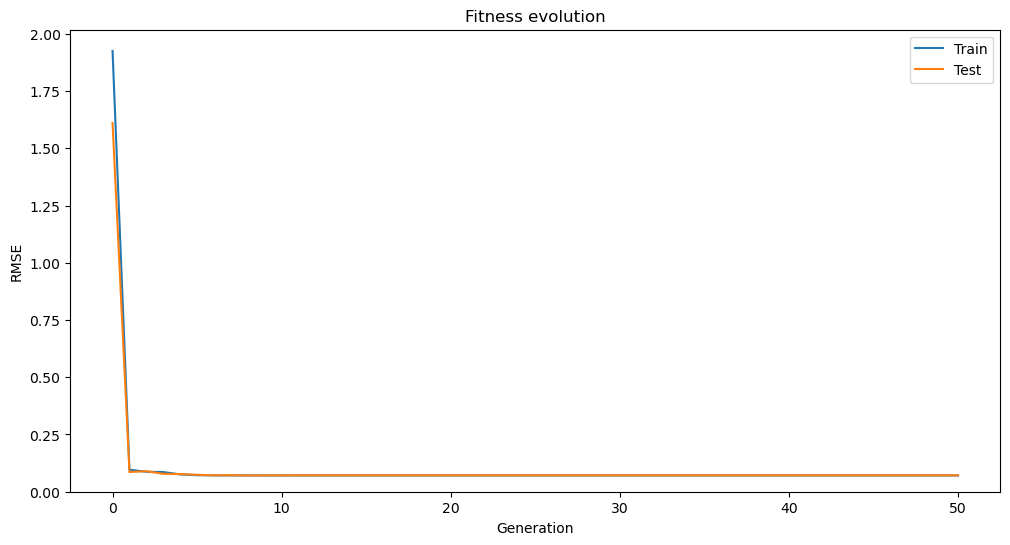

Best solution RMSE fitness: 0.07 train, 0.07 test.



In [8]:
plt.figure(figsize=(12, 6))

plt.plot(history_fits, label='Train')
plt.plot(history_test_fits, label='Test')
plt.title('Fitness evolution')
plt.xlabel('Generation')
plt.ylabel('RMSE')
plt.ylim(bottom=0)
plt.legend()
plt.show()

print('Best solution RMSE fitness: {:.2f} train, {:.2f} test.\n'.format(mheuristic.best_sol.fit.item(), mheuristic.best_sol.test_fit.item()))


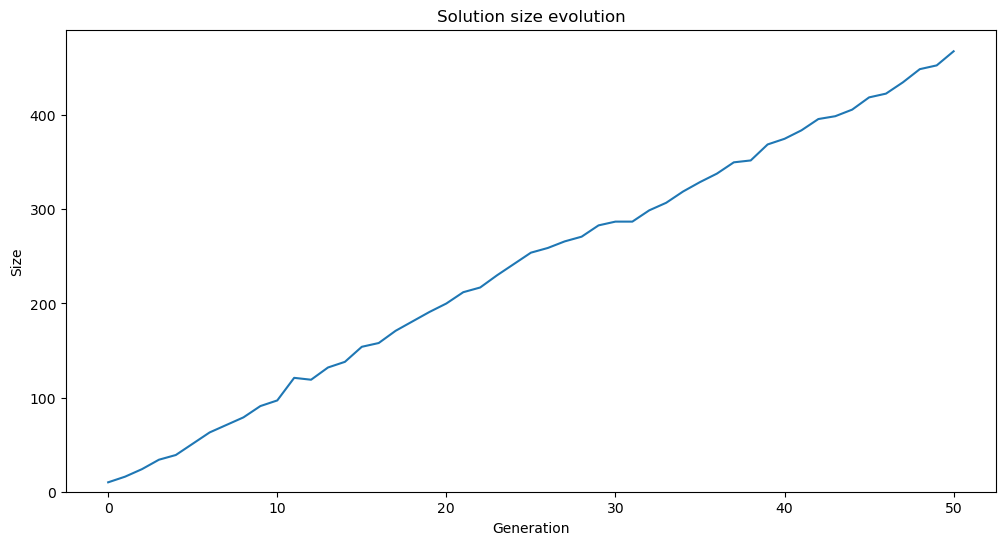

In [9]:
plt.figure(figsize=(12, 6))

plt.plot(history_sizes)
plt.title('Solution size evolution')
plt.xlabel('Generation')
plt.ylabel('Size')
plt.ylim(bottom=0)
plt.show()


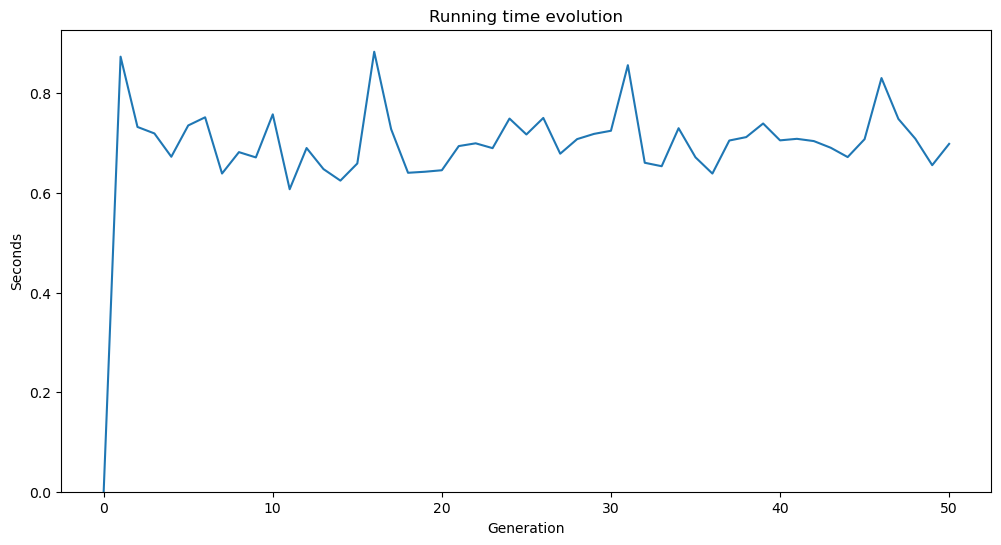

Total time: 0.59 minutes.



In [10]:
plt.figure(figsize=(12, 6))

plt.plot(history_timing)
plt.title('Running time evolution')
plt.xlabel('Generation')
plt.ylabel('Seconds')
plt.ylim(bottom=0)
plt.show()

print('Total time: {:.2f} minutes.\n'.format(sum(history_timing)/60.))
